In [1]:
# Cell 1: basic imports
import pandas as pd
import numpy as np

from google.colab import files

uploaded = files.upload()

# Load each uploaded CSV into a dict of dataframes
tables = {}
for fname in uploaded.keys():
    print("Loading:", fname)
    df = pd.read_csv(fname)
    tname = fname.replace(".csv", "").lower()
    tables[tname] = df

print("\nLoaded tables:", list(tables.keys()))



Saving refresh_token.csv to refresh_token.csv
Saving password_reset.csv to password_reset.csv
Saving power_saving_trigger.csv to power_saving_trigger.csv
Saving insight_alert.csv to insight_alert.csv
Saving bill_payment.csv to bill_payment.csv
Saving bill_occurrence.csv to bill_occurrence.csv
Saving bill.csv to bill.csv
Saving user_achievement.csv to user_achievement.csv
Saving achievement.csv to achievement.csv
Saving goal_runway.csv to goal_runway.csv
Saving insight_segment.csv to insight_segment.csv
Saving insight_daily.csv to insight_daily.csv
Saving accumulating.csv to accumulating.csv
Saving daily_balance.csv to daily_balance.csv
Saving transaction.csv to transaction.csv
Saving category.csv to category.csv
Saving budget_pref.csv to budget_pref.csv
Saving monthly_period.csv to monthly_period.csv
Saving user.csv to user.csv
Loading: refresh_token.csv
Loading: password_reset.csv
Loading: power_saving_trigger.csv
Loading: insight_alert.csv
Loading: bill_payment.csv
Loading: bill_occu

In [2]:
# Cell: normalize table names
cleaned_tables = {}

for name, df in tables.items():
    # remove anything after "(" and trim spaces, lower-case
    base = name.split("(")[0].strip().lower()
    cleaned_tables[base] = df

tables = cleaned_tables

print("Normalized table names:", list(tables.keys()))


Normalized table names: ['refresh_token', 'password_reset', 'power_saving_trigger', 'insight_alert', 'bill_payment', 'bill_occurrence', 'bill', 'user_achievement', 'achievement', 'goal_runway', 'insight_segment', 'insight_daily', 'accumulating', 'daily_balance', 'transaction', 'category', 'budget_pref', 'monthly_period', 'user']


In [3]:
# Cell: build Tier-1 base dataframe from insight_daily

idaily = tables["insight_daily"].copy()

# Parse dates
idaily["day"] = pd.to_datetime(idaily["day"])

# Sort by user & day
idaily = idaily.sort_values(["user_id", "day"]).reset_index(drop=True)

# Rolling features per user
group = idaily.groupby("user_id")

idaily["ma7_spend"] = group["spend_total_cents"].transform(
    lambda s: s.rolling(window=7, min_periods=3).mean()
)

idaily["ma7_trend"] = group["spend_total_cents"].transform(
    lambda s: s - s.shift(7)
)

idaily["ma7_vol"] = group["spend_total_cents"].transform(
    lambda s: s.rolling(window=7, min_periods=3).std().fillna(0)
)

# Day-of-week features
idaily["dow"] = idaily["day"].dt.weekday  # 0 = Monday
idaily["is_weekend"] = idaily["dow"].isin([5,6]).astype(int)

# Target: next-day spend
idaily["target_next_spend"] = group["spend_total_cents"].shift(-1)

# Drop rows where we don't have enough history or target
tier1_df = idaily.dropna(subset=["ma7_spend", "ma7_trend", "ma7_vol", "target_next_spend"]).copy()

print("Tier-1 base dataframe shape:", tier1_df.shape)
print(tier1_df[["user_id","day","spend_total_cents","ma7_spend","ma7_trend","ma7_vol","target_next_spend"]].head(10))


Tier-1 base dataframe shape: (4056, 19)
    user_id        day  spend_total_cents     ma7_spend  ma7_trend  \
7         1 2025-09-04              18512   7598.285714     4950.0   
8         1 2025-09-05              31485  10186.000000    18114.0   
9         1 2025-09-06               4420   9565.285714    -4345.0   
10        1 2025-09-07                808   9680.714286      808.0   
11        1 2025-09-08                500   9752.142857      500.0   
12        1 2025-09-09                  0   7960.714286   -12540.0   
13        1 2025-09-10              11044   9538.428571    11044.0   
14        1 2025-09-11              37196  12207.571429    18684.0   
15        1 2025-09-12                  0   7709.714286   -31485.0   
16        1 2025-09-13               1290   7262.571429    -3130.0   

         ma7_vol  target_next_spend  
7    7653.071164            31485.0  
8   11844.788038             4420.0  
9   12043.840289              808.0  
10  11940.314272              500.0  

In [4]:
# Clean USER table

user = tables["user"].copy()

# 1) Ensure id is numeric
user["id"] = user["id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# 2) Clean deleted_at → empty string
if "deleted_at" in user.columns:
    user["deleted_at"] = (
        user["deleted_at"]
        .replace(["1970-01-01 00:00:00", "1970-01-01"], "")
        .fillna("")
    )

# 3) Ensure created_at / updated_at strings are valid
for col in ["created_at", "updated_at"]:
    if col in user.columns:
        user[col] = user[col].astype(str).replace("NaT", "")

tables["user"] = user

print("USER CLEANED SUCCESSFULLY")
print(user.head())
print(user.dtypes)


USER CLEANED SUCCESSFULLY
   id      name                email password_hash              status  \
0   1  User_001  user001@example.com      hash_001              active   
1   2  User_002  user002@example.com      hash_002              active   
2   3  User_003  user003@example.com      hash_003  pending_onboarding   
3   4  User_004  user004@example.com      hash_004  pending_onboarding   
4   5  User_005  user005@example.com      hash_005              active   

           timezone           created_at  created_by  updated_at  updated_by  \
0  America/New_York  2025-08-28 07:25:12           0  2025-08-28           0   
1  America/New_York  2025-09-10 06:38:21           0  2025-09-17           0   
2  America/New_York  2025-08-27 10:49:51           0  2025-09-13           0   
3  America/New_York  2025-10-13 19:56:50           0  2025-10-26           0   
4  America/New_York  2025-08-20 09:25:57           0  2025-08-22           0   

  deleted_at  deleted_by  
0                    

In [5]:
# Cleaning BUDGET_PREF table

bp = tables["budget_pref"].copy()

# user_id numeric
bp["user_id"] = bp["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# normalizing the cadence
bp["pay_cadence"] = bp["pay_cadence"].str.lower().str.strip()

valid_cadences = {"weekly", "biweekly", "monthly"}
bp = bp[bp["pay_cadence"].isin(valid_cadences)].reset_index(drop=True)

# ensuring anchor columns exist
for col in ["pay_anchor_day_of_month", "pay_anchor_weekday", "biweekly_anchor_date"]:
    if col not in bp.columns:
        if col == "pay_anchor_day_of_month":
            bp[col] = 0
        else:
            bp[col] = ""

weekdays = ["sunday","monday","tuesday","wednesday","thursday","friday","saturday"]

# Apply cadence rules
for idx, row in bp.iterrows():
    cadence = row["pay_cadence"]

    if cadence == "monthly":
        day = int(row.get("pay_anchor_day_of_month", 1))
        if day < 1 or day > 28:
            day = 1
        bp.at[idx, "pay_anchor_day_of_month"] = day
        bp.at[idx, "pay_anchor_weekday"] = ""
        bp.at[idx, "biweekly_anchor_date"] = ""

    elif cadence == "weekly":
        wd = str(row.get("pay_anchor_weekday", "")).lower()
        if wd not in weekdays:
            wd = "friday"
        bp.at[idx, "pay_anchor_weekday"] = wd
        bp.at[idx, "pay_anchor_day_of_month"] = 0
        bp.at[idx, "biweekly_anchor_date"] = ""

    elif cadence == "biweekly":
        bad = str(row.get("biweekly_anchor_date", "")).strip()
        if bad == "" or bad.lower() == "nan":
            bad = "2025-10-01"
        bp.at[idx, "biweekly_anchor_date"] = bad
        bp.at[idx, "pay_anchor_day_of_month"] = 0
        bp.at[idx, "pay_anchor_weekday"] = ""

# expected_amount_cadence = pay_cadence
bp["expected_amount_cadence"] = bp["pay_cadence"]

tables["budget_pref"] = bp

print("BUDGET_PREF CLEANED SUCCESSFULLY")
print(bp.head())
print(bp["pay_cadence"].value_counts())


BUDGET_PREF CLEANED SUCCESSFULLY
   id  user_id pay_cadence  pay_anchor_day_of_month pay_anchor_weekday  \
0   1        1     monthly                        2                      
1   2        2      weekly                        0          wednesday   
2   3        3     monthly                       25                      
3   4        4    biweekly                        0                      
4   5        5    biweekly                        0                      

  biweekly_anchor_date  expected_amount_cents expected_amount_cadence  \
0                                      292215                 monthly   
1                                      530651                  weekly   
2                                      478466                 monthly   
3           2025-10-20                 464649                biweekly   
4           2025-08-24                 192917                biweekly   

            created_at  updated_at  
0  2025-08-28 07:25:12  2025-08-28  
1  2025-0

In [6]:
mp = tables["monthly_period"].copy()

# user_id numeric
mp["user_id"] = mp["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# cleaning month_utc
mp["month_utc"] = pd.to_datetime(mp["month_utc"], errors="coerce").dt.date

# cleaning status
mp["status"] = mp["status"].str.lower().replace({
    "active":"active",
    "closed":"closed"
})

# clean deleted placeholders if there are any left
for col in ["created_at", "updated_at"]:
    if col in mp.columns:
        mp[col] = mp[col].astype(str).replace("NaT","")

tables["monthly_period"] = mp

print("MONTHLY_PERIOD CLEANED")
print(mp.head())


MONTHLY_PERIOD CLEANED
   id  user_id   month_utc  status  opening_income_cents  \
0   1        1  2025-08-01  closed                425994   
1   2        1  2025-09-01  closed                422077   
2   3        1  2025-10-01  active                444855   
3   4        2  2025-08-01  closed                428401   
4   5        2  2025-09-01  closed                431778   

   opening_weekly_cents  opening_biweekly_cents  \
0                 83219                  166438   
1                 86941                  173882   
2                116612                  233224   
3                125799                  251598   
4                205544                  411088   

                               note           created_at  updated_at  
0  Auto-generated period 2025-08-01  2025-08-28 07:25:12  2025-08-28  
1  Auto-generated period 2025-09-01  2025-08-28 07:25:12  2025-08-28  
2  Auto-generated period 2025-10-01  2025-08-28 07:25:12  2025-08-28  
3  Auto-generated period 

In [7]:
# STEP 4: Clean TRANSACTION table

txn = tables["transaction"].copy()

print("Original transaction rows:", txn.shape)

# 1)user_id to numeric
txn["user_id"] = txn["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# 2)period_id to numeric
if "period_id" in txn.columns:
    txn["period_id"] = txn["period_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# 3)bill_payment_id
if "bill_payment_id" in txn.columns:
    txn["bill_payment_id"] = txn["bill_payment_id"].fillna(0).astype(int)

# 4) Standardizing deleted_at
if "deleted_at" in txn.columns:
    txn["deleted_at"] = txn["deleted_at"].replace(
        ["1970-01-01 00:00:00", "1970-01-01"],
        ""
    ).fillna("")

# 5) Converting timestamps to datetime
for col in ["occurred_at", "txn_date", "local_occurred_at", "txn_date_local"]:
    if col in txn.columns:
        txn[col] = pd.to_datetime(txn[col], errors="coerce")

# 6) Standardizing day_part values
if "day_part" in txn.columns:
    txn["day_part"] = txn["day_part"].str.lower().str.strip()

if "day_part_local" in txn.columns:
    txn["day_part_local"] = txn["day_part_local"].str.lower().str.strip()

# 7) Standardizing spend_class: need / want / guilt
if "spend_class" in txn.columns:
    txn["spend_class"] = txn["spend_class"].str.lower().str.strip()

# 8) Standardizing mood
if "mood" in txn.columns:
    txn["mood"] = txn["mood"].astype(str).str.lower().str.strip()

# 9) Converting category_id to numeric
txn["category_id"] = txn["category_id"].fillna(0).astype(int)

# 10) Drop rows with NO amount_cents
txn = txn[txn["amount_cents"].notna()]
txn["amount_cents"] = txn["amount_cents"].astype(int)

tables["transaction"] = txn

print("CLEANED transaction:")
print(txn.head())
print("Cleaned transaction rows:", txn.shape)


Original transaction rows: (8464, 21)
CLEANED transaction:
   id  user_id  period_id     type  amount_cents         occurred_at  \
0   1        1          3  expense           928 2025-10-24 18:33:11   
1   2        1          2  expense           500 2025-09-25 00:30:41   
2   3        1          3  expense           500 2025-10-12 12:08:43   
3   4        1          3  expense         10842 2025-11-03 22:29:51   
4   5        1          3   income        237270 2025-10-15 14:11:04   

           timezone   txn_date   day_part   local_occurred_at  ...  \
0  America/New_York 2025-10-24    evening 2025-10-24 18:33:11  ...   
1  America/New_York 2025-09-25    morning 2025-09-25 00:30:41  ...   
2  America/New_York 2025-10-12  afternoon 2025-10-12 12:08:43  ...   
3  America/New_York 2025-11-03    morning 2025-11-03 22:29:51  ...   
4  America/New_York 2025-10-15  afternoon 2025-10-15 14:11:04  ...   

  day_part_local spend_class category_id     merchant  \
0        evening       guilt  

In [8]:
# STEP 5: Clean BILLS + OCCURRENCES + PAYMENTS

bill = tables["bill"].copy()
bill_occ = tables["bill_occurrence"].copy()
bill_pay = tables["bill_payment"].copy()

print("BILL rows:", bill.shape)
print("BILL_OCC rows:", bill_occ.shape)
print("BILL_PAYMENT rows:", bill_pay.shape)

# 1) Cleaning user_id in bill
bill["user_id"] = bill["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# 2) Cleaning deleted_at placeholder
if "deleted_at" in bill.columns:
    bill["deleted_at"] = bill["deleted_at"].replace(
        ["1970-01-01 00:00:00", "1970-01-01"],
        ""
    ).fillna("")

# 3) Cleaning the timestamps in bill
for col in ["paused_at", "resumed_at", "created_at", "updated_at", "next_due_date"]:
    if col in bill.columns:
        bill[col] = pd.to_datetime(bill[col], errors="coerce")

#  BILL OCCURRENCE

# Cleaning numeric ID fields
bill_occ["bill_id"] = bill_occ["bill_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)
bill_occ["bill_payment_id"] = bill_occ["bill_payment_id"].fillna(0).astype(int)

# Cleaning timestamps
for col in ["paid_at", "created_at"]:
    bill_occ[col] = pd.to_datetime(bill_occ[col], errors="coerce")

bill_occ["due_date"] = pd.to_datetime(bill_occ["due_date"], errors="coerce")

#  BILL PAYMENT

bill_pay["bill_id"] = bill_pay["bill_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)
bill_pay["bill_occurrence_id"] = bill_pay["bill_occurrence_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

for col in ["paid_at", "created_at", "updated_at"]:
    if col in bill_pay.columns:
        bill_pay[col] = pd.to_datetime(bill_pay[col], errors="coerce")

# Replace NaN in transaction_id with 0
if "transaction_id" in bill_pay.columns:
    bill_pay["transaction_id"] = bill_pay["transaction_id"].fillna(0).astype(int)

# Save cleaned tables back
tables["bill"] = bill
tables["bill_occurrence"] = bill_occ
tables["bill_payment"] = bill_pay

print("\nCLEANED BILLS")
print(bill.head(3))
print("\nCLEANED BILL_OCCURRENCE")
print(bill_occ.head(3))
print("\nCLEANED BILL_PAYMENT")
print(bill_pay.head(3))


BILL rows: (136, 12)
BILL_OCC rows: (408, 9)
BILL_PAYMENT rows: (408, 9)

CLEANED BILLS
   id  user_id       name  amount_cents recurrence_rule  status next_due_date  \
0   1        1  Streaming        607900          weekly  active    2025-12-03   
1   2        2      Phone       1383200        biweekly  active    2025-12-12   
2   3        3       Rent       1718700        biweekly  active    2025-12-12   

   paused_at resumed_at          created_at updated_at deleted_at  
0 1970-01-01 1970-01-01 2025-08-28 07:25:12 2025-08-28             
1 1970-01-01 1970-01-01 2025-09-10 06:38:21 2025-09-17             
2 1970-01-01 1970-01-01 2025-08-27 10:49:51 2025-09-13             

CLEANED BILL_OCCURRENCE
   id  bill_id   due_date   status    paid_at  auto_txn_id  bill_payment_id  \
0   1        1 2025-10-16  skipped 1970-01-01            0                1   
1   2        1 2025-09-16      due 1970-01-01            0                2   
2   3        1 2025-08-17  skipped 1970-01-01        

In [9]:
# STEP 6: Cleaning daily_balance + insight_daily + accumulating + insight_segment

# DAILY BALANCE
db = tables["daily_balance"].copy()

# user_id numeric
db["user_id"] = db["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)

# cleaning day_local
db["day_local"] = pd.to_datetime(db["day_local"], errors="coerce")

# cleaning computed_at
db["computed_at"] = pd.to_datetime(db["computed_at"], errors="coerce")

# ensure balance values are numeric
for col in ["balance_cents", "net_change_cents"]:
    db[col] = pd.to_numeric(db[col], errors="coerce").fillna(0).astype(int)

tables["daily_balance"] = db


# INSIGHT DAILY
idaily = tables["insight_daily"].copy()

idaily["user_id"] = idaily["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)
idaily["day"] = pd.to_datetime(idaily["day"], errors="coerce")

# Converting numeric cols
num_cols = [
    "spend_total_cents", "income_total_cents", "burn_rate_cents",
    "need_cents", "want_cents", "guilt_cents", "txn_count"
]

for col in num_cols:
    if col in idaily.columns:
        idaily[col] = pd.to_numeric(idaily[col], errors="coerce").fillna(0).astype(int)

# created_at, updated_at cleanup
for col in ["created_at", "updated_at"]:
    if col in idaily.columns:
        idaily[col] = pd.to_datetime(idaily[col], errors="coerce")

tables["insight_daily"] = idaily


# ACCUMULATING
acc = tables["accumulating"].copy()

acc["user_id"] = acc["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)
acc["month_utc"] = pd.to_datetime(acc["month_utc"], errors="coerce").dt.date

for col in ["leftover_cents", "income_cents", "expense_cents"]:
    acc[col] = pd.to_numeric(acc[col], errors="coerce").fillna(0).astype(int)

tables["accumulating"] = acc


# INSIGHT SEGMENT
iseg = tables["insight_segment"].copy()

iseg["user_id"] = iseg["user_id"].astype(str).str.extract(r'(\d+)$')[0].astype(int)
iseg["segment_type"] = iseg["segment_type"].str.lower().str.strip()
iseg["segment_value"] = iseg["segment_value"].str.lower().str.strip()

# numeric columns
for col in ["amount_cents", "txn_count", "avg_amount_cents"]:
    if col in iseg.columns:
        iseg[col] = pd.to_numeric(iseg[col], errors="coerce").fillna(0).astype(int)

# date cleanup
iseg["computed_at"] = pd.to_datetime(iseg["computed_at"], errors="coerce")

tables["insight_segment"] = iseg


print("DAILY BALANCE CLEANED:", db.shape)
print(db.head(3))

print("\nINSIGHT DAILY CLEANED:", idaily.shape)
print(idaily.head(3))

print("\nACCUMULATING CLEANED:", acc.shape)
print(acc.head(3))

print("\nINSIGHT SEGMENT CLEANED:", iseg.shape)
print(iseg.head(3))


DAILY BALANCE CLEANED: (4656, 5)
   user_id  day_local  balance_cents  net_change_cents         computed_at
0        1 2025-08-28         237638            -13562 2025-08-28 23:59:00
1        1 2025-08-29         224267            -13371 2025-08-29 23:59:00
2        1 2025-08-30         215502             -8765 2025-08-30 23:59:00

INSIGHT DAILY CLEANED: (4656, 13)
   id  user_id  period_id        day  spend_total_cents  income_total_cents  \
0   1        1          1 2025-08-28              13562                   0   
1   2        1          1 2025-08-29              13371                   0   
2   3        1          1 2025-08-30               8765                   0   

   burn_rate_cents  need_cents  want_cents  guilt_cents  txn_count  \
0            13562           0       13062          500          2   
1            13371           0           0        13371          1   
2             8765        8765           0            0          1   

           created_at updated_at  

In [10]:
# STEP 9 — Time-based Train / Val / Test Split

df = tier1_df.copy().sort_values("day")

n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

print("TRAIN SHAPE:", train_df.shape)
print("VAL SHAPE:", val_df.shape)
print("TEST SHAPE:", test_df.shape)

# Features we will use
feature_cols = ["ma7_spend", "ma7_trend", "ma7_vol", "dow", "is_weekend"]
target_col = "target_next_spend"

# Extract matrices
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print("\nFeature sample:")
print(X_train.head())


TRAIN SHAPE: (2839, 19)
VAL SHAPE: (608, 19)
TEST SHAPE: (609, 19)

Feature sample:
         ma7_spend  ma7_trend       ma7_vol  dow  is_weekend
598    9640.000000     7456.0  12322.481731    0           0
4131  25488.000000    57370.0  25178.374987    0           0
599   13253.000000    25291.0  14184.015546    1           0
3973   5042.142857    -9485.0   4973.757950    1           0
3231   5797.714286     -500.0   7664.576238    1           0


In [11]:
# Converting cents to dollars for Tier-1 modeling
for col in ["spend_total_cents", "ma7_spend", "ma7_trend", "ma7_vol", "target_next_spend"]:
    tier1_df[col.replace("_cents","")] = tier1_df[col] / 100


In [12]:
# Converting cents to dollars for all spending-related columns
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error

df = tier1_df.copy()

df["spend_total"] = df["spend_total_cents"] / 100
df["target_next_spend_d"] = df["target_next_spend"] / 100

df["ma7_spend_d"] = df["ma7_spend"] / 100
df["ma7_trend_d"] = df["ma7_trend"] / 100
df["ma7_vol_d"] = df["ma7_vol"] / 100

# Re-split using the dollar version
df = df.sort_values("day")

n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# Baseline prediction in dollars
train_pred = train["ma7_spend_d"] + train["ma7_trend_d"]
val_pred = val["ma7_spend_d"] + val["ma7_trend_d"]
test_pred = test["ma7_spend_d"] + test["ma7_trend_d"]

train_pred = np.maximum(train_pred, 0)
val_pred = np.maximum(val_pred, 0)
test_pred = np.maximum(test_pred, 0)

# Evaluate again
train_mae = mean_absolute_error(train["target_next_spend_d"], train_pred)
train_rmse = np.sqrt(mean_squared_error(train["target_next_spend_d"], train_pred))

val_mae = mean_absolute_error(val["target_next_spend_d"], val_pred)
val_rmse = np.sqrt(mean_squared_error(val["target_next_spend_d"], val_pred))

test_mae = mean_absolute_error(test["target_next_spend_d"], test_pred)
test_rmse = np.sqrt(mean_squared_error(test["target_next_spend_d"], test_pred))

print(" Tier-1 Baseline Performance (DOLLARS)")
print(f"TRAIN MAE: ${train_mae:.2f} | RMSE: ${train_rmse:.2f}")
print(f"VAL   MAE: ${val_mae:.2f} | RMSE: ${val_rmse:.2f}")
print(f"TEST  MAE: ${test_mae:.2f} | RMSE: ${test_rmse:.2f}")


 Tier-1 Baseline Performance (DOLLARS)
TRAIN MAE: $1.21 | RMSE: $1.89
VAL   MAE: $1.27 | RMSE: $1.85
TEST  MAE: $1.38 | RMSE: $2.14


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Features in dollars
feature_cols = ["ma7_spend_d", "ma7_trend_d", "ma7_vol_d", "dow", "is_weekend"]

X_train = train[feature_cols]
y_train = train["target_next_spend_d"]

X_val = val[feature_cols]
y_val = val["target_next_spend_d"]

X_test = test[feature_cols]
y_test = test["target_next_spend_d"]

# Training simple Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

print("Tier-1 Linear Regression model trained.")
print("Coefficients:", dict(zip(feature_cols, lr.coef_)))
print("Intercept:", lr.intercept_)

# Prediction
train_lr_pred = np.maximum(lr.predict(X_train), 0)
val_lr_pred   = np.maximum(lr.predict(X_val), 0)
test_lr_pred  = np.maximum(lr.predict(X_test), 0)

# Metrics
def eval_set(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} → MAE: ${mae:.2f} | RMSE: ${rmse:.2f}")
    return mae, rmse

print("\n Tier-1 Linear Regression Performance (DOLLARS)")
train_lr_mae, train_lr_rmse = eval_set("TRAIN", y_train, train_lr_pred)
val_lr_mae, val_lr_rmse     = eval_set("VAL  ", y_val,   val_lr_pred)
test_lr_mae, test_lr_rmse   = eval_set("TEST ", y_test,  test_lr_pred)


Tier-1 Linear Regression model trained.
Coefficients: {'ma7_spend_d': np.float64(0.5494302851168189), 'ma7_trend_d': np.float64(-0.004707296558663851), 'ma7_vol_d': np.float64(0.11590222987576668), 'dow': np.float64(0.0007008921027266465), 'is_weekend': np.float64(-0.021985081181923136)}
Intercept: 0.2921471657384225

 Tier-1 Linear Regression Performance (DOLLARS)
TRAIN → MAE: $0.87 | RMSE: $1.25
VAL   → MAE: $0.91 | RMSE: $1.27
TEST  → MAE: $0.94 | RMSE: $1.38


In [14]:
import joblib

# Save model and feature metadata
joblib.dump(lr, "tier1_spend_model.pkl")
joblib.dump(feature_cols, "tier1_feature_cols.pkl")

print("Saved: tier1_spend_model.pkl and tier1_feature_cols.pkl")


Saved: tier1_spend_model.pkl and tier1_feature_cols.pkl


In [15]:
from google.colab import files

files.download("tier1_spend_model.pkl")
files.download("tier1_feature_cols.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

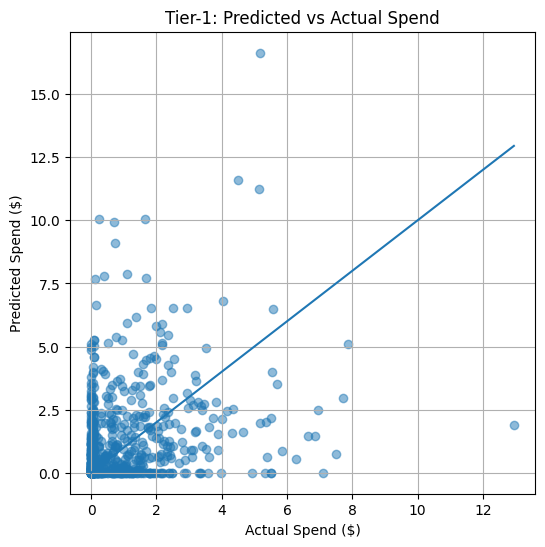

In [16]:
import matplotlib.pyplot as plt

actual = y_test
pred = test_pred

plt.figure(figsize=(6,6))
plt.scatter(actual, pred, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()])
plt.xlabel("Actual Spend ($)")
plt.ylabel("Predicted Spend ($)")
plt.title("Tier-1: Predicted vs Actual Spend")
plt.grid(True)
plt.show()


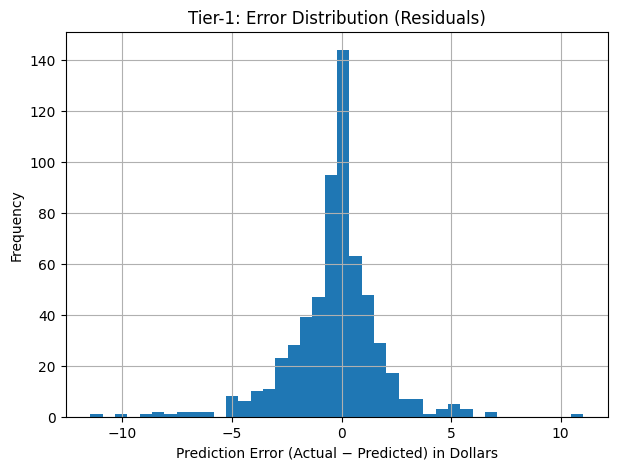

In [17]:
errors = actual - pred

plt.figure(figsize=(7,5))
plt.hist(errors, bins=40)
plt.xlabel("Prediction Error (Actual − Predicted) in Dollars")
plt.ylabel("Frequency")
plt.title("Tier-1: Error Distribution (Residuals)")
plt.grid(True)
plt.show()


In [18]:
import pandas as pd
import numpy as np

# 1) Load core tables from the tables dict
idaily = tables["insight_daily"].copy()
db = tables["daily_balance"].copy()
bp = tables["budget_pref"].copy()
gr = tables["goal_runway"].copy()

# 2) Ensure that the date columns are datetime
idaily["day"] = pd.to_datetime(idaily["day"])
db["day_local"] = pd.to_datetime(db["day_local"])
if "effective_from" in gr.columns:
    gr["effective_from"] = pd.to_datetime(gr["effective_from"], errors="coerce")
if "effective_to" in gr.columns:
    gr["effective_to"] = pd.to_datetime(gr["effective_to"], errors="coerce")

# 3) Merge daily insights with daily balance
t2 = idaily.merge(
    db[["user_id", "day_local", "balance_cents", "net_change_cents"]],
    left_on=["user_id", "day"],
    right_on=["user_id", "day_local"],
    how="left"
)

# 4) Attach pay cadence from budget_pref
t2 = t2.merge(
    bp[["user_id", "pay_cadence", "pay_anchor_day_of_month",
        "pay_anchor_weekday", "biweekly_anchor_date"]],
    on="user_id",
    how="left"
)

# 5) Attach last goal_runway per user
if len(gr) > 0:
    last_goal = gr.sort_values("effective_from").groupby("user_id").tail(1)[["user_id", "target_days"]]
    t2 = t2.merge(last_goal, on="user_id", how="left")
else:
    t2["target_days"] = np.nan

print("Tier-2 base shape:", t2.shape)
print(t2[["user_id", "day", "spend_total_cents", "income_total_cents", "balance_cents",
          "pay_cadence", "target_days"]].head(10))


Tier-2 base shape: (4656, 21)
   user_id        day  spend_total_cents  income_total_cents  balance_cents  \
0        1 2025-08-28              13562                   0         237638   
1        1 2025-08-29              13371                   0         224267   
2        1 2025-08-30               8765                   0         215502   
3        1 2025-08-31                  0              183982         399484   
4        1 2025-09-01                  0                   0         399484   
5        1 2025-09-02              12540                   0         386944   
6        1 2025-09-03                  0                   0         386944   
7        1 2025-09-04              18512              166972         535404   
8        1 2025-09-05              31485                   0         503919   
9        1 2025-09-06               4420              138767         638266   

  pay_cadence  target_days  
0     monthly           63  
1     monthly           63  
2     monthly

In [19]:
t2 = t2.sort_values(["user_id", "day"]).reset_index(drop=True)

# Convert cents to dollars
t2["spend_d"] = t2["spend_total_cents"] / 100.0
t2["income_d"] = t2["income_total_cents"] / 100.0
t2["balance_d"] = t2["balance_cents"] / 100.0

# Daily burn = daily spend
t2["burn_daily_d"] = t2["spend_d"]

# Group by user for rolling windows
grp = t2.groupby("user_id")

# Weekly burn rate: 7-day average
t2["burn7_d"] = grp["burn_daily_d"].transform(
    lambda s: s.rolling(7, min_periods=3).mean()
)

# Monthly burn rate: 30-day average
t2["burn30_d"] = grp["burn_daily_d"].transform(
    lambda s: s.rolling(30, min_periods=7).mean()
)

print("Burn features sample:")
print(t2[["user_id", "day", "spend_d", "burn_daily_d", "burn7_d", "burn30_d"]].head(15))


Burn features sample:
    user_id        day  spend_d  burn_daily_d     burn7_d    burn30_d
0         1 2025-08-28   135.62        135.62         NaN         NaN
1         1 2025-08-29   133.71        133.71         NaN         NaN
2         1 2025-08-30    87.65         87.65  118.993333         NaN
3         1 2025-08-31     0.00          0.00   89.245000         NaN
4         1 2025-09-01     0.00          0.00   71.396000         NaN
5         1 2025-09-02   125.40        125.40   80.396667         NaN
6         1 2025-09-03     0.00          0.00   68.911429   68.911429
7         1 2025-09-04   185.12        185.12   75.982857   83.437500
8         1 2025-09-05   314.85        314.85  101.860000  109.150000
9         1 2025-09-06    44.20         44.20   95.652857  102.655000
10        1 2025-09-07     8.08          8.08   96.807143   94.057273
11        1 2025-09-08     5.00          5.00   97.521429   86.635833
12        1 2025-09-09     0.00          0.00   79.607143   79.97153

In [20]:
# Use weekly burn rate to estimate runway
burn_safe = t2["burn7_d"].copy()
burn_safe[burn_safe <= 1e-3] = 1.0  # minimum burn of $1/day

t2["runway_days"] = t2["balance_d"] / burn_safe

print("Runway sample:")
print(t2[["user_id", "day", "balance_d", "burn7_d", "runway_days"]].head(15))


Runway sample:
    user_id        day  balance_d     burn7_d  runway_days
0         1 2025-08-28    2376.38         NaN          NaN
1         1 2025-08-29    2242.67         NaN          NaN
2         1 2025-08-30    2155.02  118.993333    18.110426
3         1 2025-08-31    3994.84   89.245000    44.762620
4         1 2025-09-01    3994.84   71.396000    55.953275
5         1 2025-09-02    3869.44   80.396667    48.129359
6         1 2025-09-03    3869.44   68.911429    56.150918
7         1 2025-09-04    5354.04   75.982857    70.463789
8         1 2025-09-05    5039.19  101.860000    49.471726
9         1 2025-09-06    6382.66   95.652857    66.727332
10        1 2025-09-07    6374.58   96.807143    65.848240
11        1 2025-09-08    6369.58   97.521429    65.314671
12        1 2025-09-09    6369.58   79.607143    80.012669
13        1 2025-09-10    6259.14   95.384286    65.620243
14        1 2025-09-11    5887.18  122.075714    48.225645


In [21]:
eps = 1e-6

t2["need_ratio"] = np.where(t2["spend_total_cents"] > 0,
                            t2["need_cents"] / (t2["spend_total_cents"] + eps), 0)
t2["want_ratio"] = np.where(t2["spend_total_cents"] > 0,
                            t2["want_cents"] / (t2["spend_total_cents"] + eps), 0)
t2["guilt_ratio"] = np.where(t2["spend_total_cents"] > 0,
                             t2["guilt_cents"] / (t2["spend_total_cents"] + eps), 0)

t2["dow"] = t2["day"].dt.weekday
t2["is_weekend"] = t2["dow"].isin([5, 6]).astype(int)

print(t2[["user_id", "day", "need_ratio", "want_ratio", "guilt_ratio", "dow", "is_weekend"]].head(10))


   user_id        day  need_ratio  want_ratio  guilt_ratio  dow  is_weekend
0        1 2025-08-28    0.000000    0.963132     0.036868    3           0
1        1 2025-08-29    0.000000    0.000000     1.000000    4           0
2        1 2025-08-30    1.000000    0.000000     0.000000    5           1
3        1 2025-08-31    0.000000    0.000000     0.000000    6           1
4        1 2025-09-01    0.000000    0.000000     0.000000    0           0
5        1 2025-09-02    1.000000    0.000000     0.000000    1           0
6        1 2025-09-03    0.000000    0.000000     0.000000    2           0
7        1 2025-09-04    9.019663    1.000000     0.000000    3           0
8        1 2025-09-05    0.000000    1.000000     0.000000    4           0
9        1 2025-09-06   31.395249    0.000000     1.000000    5           1


In [22]:
# Ensure the cadence is lowercase
t2["pay_cadence"] = t2["pay_cadence"].fillna("monthly").astype(str).str.lower()

# Cycle length
def cycle_len(c):
    if c == "weekly":
        return 7
    if c == "biweekly":
        return 14
    if c == "monthly":
        return 30
    return 30

t2["cycle_len"] = t2["pay_cadence"].apply(cycle_len)

# Prepare weekday name and index mapping
weekday_idx = {
    "monday": 0, "tuesday": 1, "wednesday": 2,
    "thursday": 3, "friday": 4, "saturday": 5, "sunday": 6
}

# Initializing empty columns
t2["days_since_pay"] = np.nan
t2["days_until_pay"] = np.nan

# MONTHLY CADENCE
mask_monthly = t2["pay_cadence"] == "monthly"
if mask_monthly.any():
    anchor_day = t2.loc[mask_monthly, "pay_anchor_day_of_month"].fillna(1).astype(int)
    dom = t2.loc[mask_monthly, "day"].dt.day
    delta = dom - anchor_day            # distance from payday
    days_since = delta % 30
    t2.loc[mask_monthly, "days_since_pay"] = days_since
    t2.loc[mask_monthly, "days_until_pay"] = 30 - days_since

#  WEEKLY CADENCE
mask_weekly = t2["pay_cadence"] == "weekly"
if mask_weekly.any():
    anchor_wd = t2.loc[mask_weekly, "pay_anchor_weekday"].map(weekday_idx).fillna(0).astype(int)
    dow = t2.loc[mask_weekly, "day"].dt.weekday
    delta = dow - anchor_wd
    days_since = delta % 7
    t2.loc[mask_weekly, "days_since_pay"] = days_since
    t2.loc[mask_weekly, "days_until_pay"] = 7 - days_since

# BIWEEKLY CADENCE
mask_biweekly = t2["pay_cadence"] == "biweekly"
if mask_biweekly.any():
    anchor_dates = pd.to_datetime(t2.loc[mask_biweekly, "biweekly_anchor_date"], errors="coerce")
    current = t2.loc[mask_biweekly, "day"]
    delta_days = (current - anchor_dates).dt.days
    days_since = (delta_days % 14)
    t2.loc[mask_biweekly, "days_since_pay"] = days_since
    t2.loc[mask_biweekly, "days_until_pay"] = 14 - days_since

# Normalize cycle position between 0 to 1
t2["cycle_position"] = t2["days_since_pay"] / t2["cycle_len"]
t2["is_payday"] = (t2["days_since_pay"] == 0).astype(int)

print("Pay-cycle sample:")
print(t2[[
    "user_id", "day", "pay_cadence", "days_since_pay", "days_until_pay",
    "cycle_len", "cycle_position", "is_payday"
]].head(15))


Pay-cycle sample:
    user_id        day pay_cadence  days_since_pay  days_until_pay  cycle_len  \
0         1 2025-08-28     monthly            26.0             4.0         30   
1         1 2025-08-29     monthly            27.0             3.0         30   
2         1 2025-08-30     monthly            28.0             2.0         30   
3         1 2025-08-31     monthly            29.0             1.0         30   
4         1 2025-09-01     monthly            29.0             1.0         30   
5         1 2025-09-02     monthly             0.0            30.0         30   
6         1 2025-09-03     monthly             1.0            29.0         30   
7         1 2025-09-04     monthly             2.0            28.0         30   
8         1 2025-09-05     monthly             3.0            27.0         30   
9         1 2025-09-06     monthly             4.0            26.0         30   
10        1 2025-09-07     monthly             5.0            25.0         30   
11        

In [23]:
# Sort by user and day for correct shifting
t2 = t2.sort_values(["user_id", "day"]).reset_index(drop=True)
grp = t2.groupby("user_id")

# Target A: next-day weekly burn rate
t2["target_next_burn7_d"] = grp["burn7_d"].shift(-1)

# Target B: next-day runway
t2["target_next_runway_days"] = grp["runway_days"].shift(-1)

# Drop rows missing targets
t2_model = t2.dropna(subset=[
    "burn7_d", "burn30_d", "runway_days",
    "need_ratio", "want_ratio", "guilt_ratio",
    "days_since_pay", "days_until_pay", "cycle_position",
    "dow", "is_weekend",
    "target_next_burn7_d", "target_next_runway_days"
]).copy()

print("Tier-2 modeling dataframe shape:", t2_model.shape)
print(t2_model[[
    "user_id", "day",
    "burn7_d", "burn30_d", "runway_days",
    "target_next_burn7_d", "target_next_runway_days"
]].head(10))


Tier-2 modeling dataframe shape: (4131, 40)
    user_id        day     burn7_d    burn30_d  runway_days  \
6         1 2025-09-03   68.911429   68.911429    56.150918   
7         1 2025-09-04   75.982857   83.437500    70.463789   
8         1 2025-09-05  101.860000  109.150000    49.471726   
9         1 2025-09-06   95.652857  102.655000    66.727332   
10        1 2025-09-07   96.807143   94.057273    65.848240   
11        1 2025-09-08   97.521429   86.635833    65.314671   
12        1 2025-09-09   79.607143   79.971538    80.012669   
13        1 2025-09-10   95.384286   82.147857    65.620243   
14        1 2025-09-11  122.075714  101.468667    48.225645   
15        1 2025-09-12   77.097143   95.126875    76.360547   

    target_next_burn7_d  target_next_runway_days  
6             75.982857                70.463789  
7            101.860000                49.471726  
8             95.652857                66.727332  
9             96.807143                65.848240  
10     

In [24]:
# Sort by user and date
t2 = t2.sort_values(["user_id", "day"]).reset_index(drop=True)
grp = t2.groupby("user_id")

# Targets for Tier-2
t2["target_next_burn7_d"] = grp["burn7_d"].shift(-1)
t2["target_next_runway_days"] = grp["runway_days"].shift(-1)

# Required features
required_cols = [
    "burn7_d", "burn30_d", "runway_days",
    "need_ratio", "want_ratio", "guilt_ratio",
    "days_since_pay", "days_until_pay", "cycle_position",
    "dow", "is_weekend"
]

# Build modeling dataset
t2_model = t2.dropna(
    subset=required_cols + ["target_next_burn7_d", "target_next_runway_days"]
).copy()

print("Tier-2 modeling dataframe shape:", t2_model.shape)
print(t2_model[[
    "user_id", "day",
    "burn7_d", "burn30_d", "runway_days",
    "target_next_burn7_d", "target_next_runway_days"
]].head(10))


Tier-2 modeling dataframe shape: (4131, 40)
    user_id        day     burn7_d    burn30_d  runway_days  \
6         1 2025-09-03   68.911429   68.911429    56.150918   
7         1 2025-09-04   75.982857   83.437500    70.463789   
8         1 2025-09-05  101.860000  109.150000    49.471726   
9         1 2025-09-06   95.652857  102.655000    66.727332   
10        1 2025-09-07   96.807143   94.057273    65.848240   
11        1 2025-09-08   97.521429   86.635833    65.314671   
12        1 2025-09-09   79.607143   79.971538    80.012669   
13        1 2025-09-10   95.384286   82.147857    65.620243   
14        1 2025-09-11  122.075714  101.468667    48.225645   
15        1 2025-09-12   77.097143   95.126875    76.360547   

    target_next_burn7_d  target_next_runway_days  
6             75.982857                70.463789  
7            101.860000                49.471726  
8             95.652857                66.727332  
9             96.807143                65.848240  
10     

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np

# Features for both Tier-2 models
t2_features = [
    "burn7_d", "burn30_d", "runway_days",
    "need_ratio", "want_ratio", "guilt_ratio",
    "days_since_pay", "days_until_pay", "cycle_position",
    "dow", "is_weekend"
]

# Inputs and Targets
X = t2_model[t2_features].copy()
y_burn = t2_model["target_next_burn7_d"].copy()
y_runway = t2_model["target_next_runway_days"].copy()

# Train / validation / test split
X_train, X_temp, y_burn_train, y_burn_temp, y_run_train, y_run_temp = train_test_split(
    X, y_burn, y_runway, test_size=0.30, random_state=42
)

X_val, X_test, y_burn_val, y_burn_test, y_run_val, y_run_test = train_test_split(
    X_temp, y_burn_temp, y_run_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (2891, 11)
Val:   (620, 11)
Test:  (620, 11)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train Model A : Burn prediction
burn_model = LinearRegression()
burn_model.fit(X_train, y_burn_train)

# Predictions
train_pred_burn = burn_model.predict(X_train)
val_pred_burn = burn_model.predict(X_val)
test_pred_burn = burn_model.predict(X_test)

# Evaluation
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

print(" Tier-2 Burn Prediction Performance ")
print(f"TRAIN → MAE: {mean_absolute_error(y_burn_train, train_pred_burn):.2f} | RMSE: {rmse(y_burn_train, train_pred_burn):.2f}")
print(f"VAL   → MAE: {mean_absolute_error(y_burn_val, val_pred_burn):.2f} | RMSE: {rmse(y_burn_val, val_pred_burn):.2f}")
print(f"TEST  → MAE: {mean_absolute_error(y_burn_test, test_pred_burn):.2f} | RMSE: {rmse(y_burn_test, test_pred_burn):.2f}")


 Tier-2 Burn Prediction Performance 
TRAIN → MAE: 15.64 | RMSE: 23.55
VAL   → MAE: 15.29 | RMSE: 23.66
TEST  → MAE: 16.78 | RMSE: 26.23


In [27]:
#  Train Model B: Runway prediction
runway_model = LinearRegression()
runway_model.fit(X_train, y_run_train)

# Predictions
train_pred_run = runway_model.predict(X_train)
val_pred_run = runway_model.predict(X_val)
test_pred_run = runway_model.predict(X_test)

print("==== Tier-2 Runway Prediction Performance (Days) ====")
print(f"TRAIN → MAE: {mean_absolute_error(y_run_train, train_pred_run):.2f} | RMSE: {rmse(y_run_train, train_pred_run):.2f}")
print(f"VAL   → MAE: {mean_absolute_error(y_run_val, val_pred_run):.2f} | RMSE: {rmse(y_run_val, val_pred_run):.2f}")
print(f"TEST  → MAE: {mean_absolute_error(y_run_test, test_pred_run):.2f} | RMSE: {rmse(y_run_test, test_pred_run):.2f}")


==== Tier-2 Runway Prediction Performance (Days) ====
TRAIN → MAE: 138.37 | RMSE: 474.75
VAL   → MAE: 139.00 | RMSE: 519.31
TEST  → MAE: 161.02 | RMSE: 608.40


In [28]:
import joblib

# Save burn model
joblib.dump(burn_model, "tier2_burn_model.pkl")

# Save runway model
joblib.dump(runway_model, "tier2_runway_model.pkl")

# Save feature list
joblib.dump(t2_features, "tier2_feature_cols.pkl")

print("Tier-2 models saved!")


Tier-2 models saved!


In [29]:
import numpy as np

# Initialize prediction columns with NaN
t2["pred_burn7_d"] = np.nan
t2["pred_runway_days"] = np.nan

# Only keep rows where all model features are present and no Nans
feat_ok_mask = t2[t2_features].notna().all(axis=1)

print("Rows with full features for prediction:", feat_ok_mask.sum(), "out of", len(t2))

# Predict only on valid rows
t2.loc[feat_ok_mask, "pred_burn7_d"] = burn_model.predict(
    t2.loc[feat_ok_mask, t2_features]
)

t2.loc[feat_ok_mask, "pred_runway_days"] = runway_model.predict(
    t2.loc[feat_ok_mask, t2_features]
)

print(
    t2.loc[feat_ok_mask, [
        "user_id", "day", "burn7_d", "runway_days",
        "pred_burn7_d", "pred_runway_days"
    ]].head(15)
)


Rows with full features for prediction: 4206 out of 4656
    user_id        day     burn7_d  runway_days  pred_burn7_d  \
6         1 2025-09-03   68.911429    56.150918     66.354605   
7         1 2025-09-04   75.982857    70.463789     75.042649   
8         1 2025-09-05  101.860000    49.471726    100.101139   
9         1 2025-09-06   95.652857    66.727332     94.998110   
10        1 2025-09-07   96.807143    65.848240     93.846256   
11        1 2025-09-08   97.521429    65.314671     94.594875   
12        1 2025-09-09   79.607143    80.012669     77.633438   
13        1 2025-09-10   95.384286    65.620243     92.370665   
14        1 2025-09-11  122.075714    48.225645    116.927502   
15        1 2025-09-12   77.097143    76.360547     77.271407   
16        1 2025-09-13   72.625714    80.884299     74.045365   
17        1 2025-09-14   71.471429    82.190606     71.957759   
18        1 2025-09-15   91.988571    62.243167     90.987131   
19        1 2025-09-16  100.94428

In [30]:
import joblib

joblib.dump(burn_model, "tier2_burn_model.pkl")
joblib.dump(runway_model, "tier2_runway_model.pkl")
joblib.dump(t2_features, "tier2_feature_cols.pkl")

print("Tier-2 models saved.")


Tier-2 models saved.


In [31]:
from google.colab import files

files.download("tier2_burn_model.pkl")
files.download("tier2_runway_model.pkl")
files.download("tier2_feature_cols.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import pandas as pd
import numpy as np

# Handling missing values
def get(row, col, default=None):
    return row[col] if col in row and pd.notna(row[col]) else default

alerts = []
ps_triggers = []

# We treat this as a simulated "insight engine" pass over all user-days
for idx, row in t2.iterrows():
    user_id = row["user_id"]
    day = row["day"]

    spend_d    = get(row, "spend_d", 0.0)
    burn7      = get(row, "burn7_d", 0.0)
    burn30     = get(row, "burn30_d", 0.0)
    runway     = get(row, "runway_days", None)
    pred_burn7 = get(row, "pred_burn7_d", None)
    pred_runway = get(row, "pred_runway_days", None)
    need_ratio  = get(row, "need_ratio", 0.0)
    want_ratio  = get(row, "want_ratio", 0.0)
    guilt_ratio = get(row, "guilt_ratio", 0.0)
    days_until_pay = get(row, "days_until_pay", None)
    days_since_pay = get(row, "days_since_pay", None)
    cycle_position = get(row, "cycle_position", None)
    target_days    = get(row, "target_days", None)

    # 1) Daily overspending alert
    # Condition: spending much higher than weekly burn
    if burn7 and spend_d > burn7 * 1.5 and spend_d > 20:
        alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "overspend_day",
            "title": "Daily overspending alert",
            "message": (
                f"You spent ${spend_d:.0f} today, which is much higher than "
                f"your usual daily average of ${burn7:.0f}."
            ),
            "severity": "warn",
        })

    #  2) Weekly overspending trend
    # Condition: weekly burn > 25% above monthly level
    if burn30 and burn7 and burn7 > burn30 * 1.25:
        alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "overspend_week",
            "title": "Weekly overspending trend",
            "message": (
                "Your recent weekly spending is more than 25% higher than your "
                "usual monthly level. You might be drifting off track."
            ),
            "severity": "warn",
        })

    # 3) Low runway before payday
    # Condition: payday close + runway shorter than days_until_pay
    if (
        runway is not None and days_until_pay is not None
        and days_until_pay <= 3 and runway < days_until_pay
    ):
        alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "runway_before_payday",
            "title": "Risk of running out before payday",
            "message": (
                f"Payday is in {days_until_pay:.0f} days, but your current runway "
                f"is only {runway:.0f} days. You may run out of money before payday."
            ),
            "severity": "critical",
        })

    # 4) Early-cycle overspending
    # Condition: early in pay cycle + heavy spend vs weekly
    if (
        cycle_position is not None and cycle_position < 0.3
        and burn7 and spend_d > burn7 * 1.5 and spend_d > 20
    ):
        alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "early_cycle_overspend",
            "title": "Heavy spending early in pay cycle",
            "message": (
                "You're spending much faster than usual early in your pay cycle. "
                "If this continues, your money may not last until your next payday."
            ),
            "severity": "warn",
        })

    # 5) Power-saving trigger
    # Use predicted runway vs user's target_days from goal_runway table
    if (
        target_days is not None and pred_runway is not None
        and target_days > 0 and pred_runway < 0.7 * target_days
    ):
        threshold_ratio = pred_runway / target_days
        # Suggested daily budget to hit target_days with current balance
        balance_d = get(row, "balance_d", None)
        suggested_budget = None
        if balance_d is not None and balance_d > 0:
            suggested_budget = balance_d / target_days

        # Power saving trigger
        ps_triggers.append({
            "user_id": user_id,
            "day": day,
            "triggered_at": day,
            "goal_days": target_days,
            "current_days_left": pred_runway,
            "threshold_ratio": round(threshold_ratio, 2),
            "suggested_daily_budget_dollars": suggested_budget,
        })

        # Matching critical alert for the user
        alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "power_saving_triggered",
            "title": "Power Saving Mode recommended",
            "message": (
                f"Your predicted runway is only {pred_runway:.0f} days versus your "
                f"goal of {int(target_days)} days. We recommend switching to a daily "
                f"budget of about ${suggested_budget:.0f} to get back on track."
                if suggested_budget is not None else
                "Your predicted runway is well below your goal. We recommend "
                "reducing discretionary spending to recover."
            ),
            "severity": "critical",
        })

# Convert to DataFrames simulate insight_alert & power_saving_trigger tables
insight_alert_df = pd.DataFrame(alerts)
power_saving_df = pd.DataFrame(ps_triggers)

print("Insight alerts shape:", insight_alert_df.shape)
print("Power saving triggers shape:", power_saving_df.shape)
print("\nSample alerts:")
print(insight_alert_df.head(10))
print("\nSample power-saving triggers:")
print(power_saving_df.head(10))


Insight alerts shape: (2734, 7)
Power saving triggers shape: (82, 7)

Sample alerts:
   user_id        day source                   code  \
0        1 2025-09-02     ml          overspend_day   
1        1 2025-09-02     ml  early_cycle_overspend   
2        1 2025-09-04     ml          overspend_day   
3        1 2025-09-04     ml  early_cycle_overspend   
4        1 2025-09-05     ml          overspend_day   
5        1 2025-09-05     ml  early_cycle_overspend   
6        1 2025-09-11     ml          overspend_day   
7        1 2025-09-15     ml          overspend_day   
8        1 2025-09-21     ml          overspend_day   
9        1 2025-09-23     ml          overspend_day   

                               title  \
0           Daily overspending alert   
1  Heavy spending early in pay cycle   
2           Daily overspending alert   
3  Heavy spending early in pay cycle   
4           Daily overspending alert   
5  Heavy spending early in pay cycle   
6           Daily overspendin

In [33]:
insight_alert_df.to_csv("insight_alert_ml.csv", index=False)
power_saving_df.to_csv("power_saving_trigger_ml.csv", index=False)


In [34]:
# Saving ML-generated alerts
insight_alert_df.to_csv("insight_alert_ml_v1.csv", index=False)

# Saving power-saving triggers
power_saving_df.to_csv("power_saving_trigger_ml_v1.csv", index=False)

print("Files saved:")
print(" - insight_alert_ml_v1.csv")
print(" - power_saving_trigger_ml_v1.csv")


Files saved:
 - insight_alert_ml_v1.csv
 - power_saving_trigger_ml_v1.csv


In [35]:
from google.colab import files

files.download("insight_alert_ml_v1.csv")
files.download("power_saving_trigger_ml_v1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import pandas as pd
import numpy as np

# Extract needed tables
txn = tables["transaction"].copy()
daily = t2.copy()   # using Tier-2 daily dataset

# Prepare transaction timestamps
txn["local_occurred_at"] = pd.to_datetime(txn["local_occurred_at"])
txn["txn_date_local"] = pd.to_datetime(txn["txn_date_local"])

# 1. LATE-NIGHT SPEND SHARE (after 10pm)
txn["is_late_night"] = txn["day_part_local"].isin(["late_night"]).astype(int)

# Total spend per day
daily_spend = txn.groupby(["user_id", "txn_date_local"])["amount_cents"].sum().rename("total_spend_cents")

# Late-night spend per day
late_spend = txn.groupby(["user_id", "txn_date_local", "is_late_night"])["amount_cents"].sum().reset_index()
late_spend = late_spend[late_spend["is_late_night"] == 1][["user_id", "txn_date_local", "amount_cents"]]
late_spend = late_spend.rename(columns={"amount_cents": "late_spend_cents"})

# Merge to compute shares
late_merge = daily_spend.to_frame().merge(late_spend, on=["user_id", "txn_date_local"], how="left")
late_merge["late_spend_cents"] = late_merge["late_spend_cents"].fillna(0)

late_merge["late_night_share"] = late_merge["late_spend_cents"] / late_merge["total_spend_cents"]
late_merge["late_night_share"] = late_merge["late_night_share"].fillna(0)

# Behavior label 1: LATE NIGHT DAY
late_merge["is_late_night_day"] = (late_merge["late_night_share"] > 0.20).astype(int)

# Prepare for merge with Tier-2 dataset
late_merge = late_merge.rename(columns={"txn_date_local": "day"})

# 2. OVESPEND LABEL
overspend_df = daily.copy()
overspend_df["is_overspend_day"] = (
    (overspend_df["spend_d"] > overspend_df["burn7_d"] * 1.5) &
    (overspend_df["spend_d"] > 20)
).astype(int)

# 3. GUILT-HEAVY LABEL
overspend_df["is_guilt_heavy_day"] = (overspend_df["guilt_ratio"] > 0.30).astype(int)

# Merge all labels into Tier-2 dataset
t3 = daily.merge(
    late_merge[["user_id", "day", "late_night_share", "is_late_night_day"]],
    on=["user_id", "day"],
    how="left"
)

t3["is_late_night_day"] = t3["is_late_night_day"].fillna(0).astype(int)
t3["late_night_share"] = t3["late_night_share"].fillna(0)

t3["is_overspend_day"] = overspend_df["is_overspend_day"]
t3["is_guilt_heavy_day"] = overspend_df["is_guilt_heavy_day"]

print("Tier-3 Modeling Frame Shape:", t3.shape)
print(t3[["user_id", "day", "is_late_night_day", "is_overspend_day", "is_guilt_heavy_day"]].head(15))


Tier-3 Modeling Frame Shape: (4656, 46)
    user_id        day  is_late_night_day  is_overspend_day  \
0         1 2025-08-28                  0                 0   
1         1 2025-08-29                  1                 0   
2         1 2025-08-30                  0                 0   
3         1 2025-08-31                  0                 0   
4         1 2025-09-01                  0                 0   
5         1 2025-09-02                  0                 1   
6         1 2025-09-03                  0                 0   
7         1 2025-09-04                  1                 1   
8         1 2025-09-05                  0                 1   
9         1 2025-09-06                  0                 0   
10        1 2025-09-07                  0                 0   
11        1 2025-09-08                  0                 0   
12        1 2025-09-09                  0                 0   
13        1 2025-09-10                  0                 0   
14        1 202

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Tier-3 feature set
t3_features = [
    "burn7_d", "burn30_d", "spend_d",
    "need_ratio", "want_ratio", "guilt_ratio",
    "days_since_pay", "days_until_pay", "cycle_position",
    "dow", "is_weekend"
]

# Clean rows — drop days with missing features
t3_clean = t3.dropna(subset=t3_features)

print("Tier-3 clean shape:", t3_clean.shape)

# Function to train a behavior model
def train_behavior_model(df, target):
    X = df[t3_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    pred_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, (pred_prob > 0.5).astype(int))
    auc = roc_auc_score(y_test, pred_prob)

    print(f"\n {target.upper()} MODEL PERFORMANCE ")
    print(f"Accuracy: {acc:.3f}")
    print(f"AUC: {auc:.3f}")

    return model

# Training all 3 behavior models
late_night_model = train_behavior_model(t3_clean, "is_late_night_day")
overspend_model  = train_behavior_model(t3_clean, "is_overspend_day")
guilt_model      = train_behavior_model(t3_clean, "is_guilt_heavy_day")


Tier-3 clean shape: (4206, 46)

 IS_LATE_NIGHT_DAY MODEL PERFORMANCE 
Accuracy: 0.899
AUC: 0.655

 IS_OVERSPEND_DAY MODEL PERFORMANCE 
Accuracy: 0.996
AUC: 1.000

 IS_GUILT_HEAVY_DAY MODEL PERFORMANCE 
Accuracy: 0.987
AUC: 1.000


In [38]:
# Add prediction probabilities for all days with full features
t3["risk_late_night"] = np.nan
t3["risk_overspend"]  = np.nan
t3["risk_guilt"]      = np.nan

# Only rows that have valid feature rows
mask = t3[t3_features].notna().all(axis=1)

# Predict probabilities
t3.loc[mask, "risk_late_night"] = late_night_model.predict_proba(t3.loc[mask, t3_features])[:, 1]
t3.loc[mask, "risk_overspend"]  = overspend_model.predict_proba(t3.loc[mask, t3_features])[:, 1]
t3.loc[mask, "risk_guilt"]      = guilt_model.predict_proba(t3.loc[mask, t3_features])[:, 1]

print(t3[[
    "user_id", "day",
    "risk_late_night", "risk_overspend", "risk_guilt"
]].head(15))


    user_id        day  risk_late_night  risk_overspend  risk_guilt
0         1 2025-08-28              NaN             NaN         NaN
1         1 2025-08-29              NaN             NaN         NaN
2         1 2025-08-30              NaN             NaN         NaN
3         1 2025-08-31              NaN             NaN         NaN
4         1 2025-09-01              NaN             NaN         NaN
5         1 2025-09-02              NaN             NaN         NaN
6         1 2025-09-03         0.061391    1.719675e-32    0.006977
7         1 2025-09-04         0.130871    1.000000e+00    0.006799
8         1 2025-09-05         0.166763    1.000000e+00    0.008183
9         1 2025-09-06         0.109666    2.181456e-31    0.999815
10        1 2025-09-07         0.060015    7.006735e-43    0.008093
11        1 2025-09-08         0.085088    1.794504e-43    0.006358
12        1 2025-09-09         0.058386    1.969879e-37    0.008123
13        1 2025-09-10         0.136286    8.930

In [39]:
behavior_alerts = []

for idx, row in t3.iterrows():
    user_id = row["user_id"]
    day = row["day"]

    # Extract features / risks
    rl = row["risk_late_night"]
    ro = row["risk_overspend"]
    rg = row["risk_guilt"]
    spend = row["spend_d"]
    burn7 = row["burn7_d"]
    burn30 = row["burn30_d"]
    need = row["need_ratio"]
    want = row["want_ratio"]
    guilt = row["guilt_ratio"]
    is_weekend = row["is_weekend"]
    cycle_pos = row["cycle_position"]
    days_until_pay = row["days_until_pay"]
    runway = row.get("runway_days", None)

    # 1) Late-night spending risk
    if rl is not None and rl > 0.40:
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "risk_late_night",
            "title": "High late-night spending risk",
            "message": "You may spend late tonight based on your past spending patterns.",
            "severity": "warn"
        })

    # 2) Overspend risk alert
    if ro is not None and ro > 0.50:
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "risk_overspend",
            "title": "High overspending risk",
            "message": "You are at high risk of overspending based on your recent financial behavior.",
            "severity": "critical"
        })

    # 3) Guilt-spending warning
    if rg is not None and rg > 0.50:
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "risk_guilt_spending",
            "title": "High guilt-based spending risk",
            "message": "Your spending shows patterns of emotional or guilt-driven purchases.",
            "severity": "warn"
        })

    # 4) Want-spending spike
    if want > 0.60:
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "want_spike",
            "title": "High want-spending today",
            "message": "You are spending mostly on 'want' items today. Keep an eye on discretionary habits.",
            "severity": "info"
        })

    # 5) Weekend spending pattern
    if is_weekend == 1 and spend > burn7 * 1.3:
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "weekend_spike",
            "title": "Weekend spending spike",
            "message": "Your weekend spending is significantly above your usual weekly levels.",
            "severity": "warn"
        })

    # 6) End-of-cycle danger
    if (
        cycle_pos is not None and cycle_pos > 0.75 and
        burn7 > burn30 and
        runway is not None and days_until_pay is not None and
        runway < days_until_pay
    ):
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "end_cycle_danger",
            "title": "End of cycle overspend risk",
            "message": "Near the end of your pay cycle, and your spending is rising above normal.",
            "severity": "critical"
        })

    # 7) Emotional spending pattern
    if (want + guilt) > 0.50:
        behavior_alerts.append({
            "user_id": user_id,
            "day": day,
            "source": "ml",
            "code": "emotional_spending",
            "title": "Emotional spending detected",
            "message": "You may be engaging in emotional spending today (wants + guilt are high).",
            "severity": "info"
        })

# Convert to dataframe
behavior_alerts_df = pd.DataFrame(behavior_alerts)
print("Behavior Alerts Shape:", behavior_alerts_df.shape)
print(behavior_alerts_df.head(10))


Behavior Alerts Shape: (5957, 7)
   user_id        day source                 code  \
0        1 2025-08-28     ml           want_spike   
1        1 2025-08-28     ml   emotional_spending   
2        1 2025-08-29     ml   emotional_spending   
3        1 2025-09-04     ml       risk_overspend   
4        1 2025-09-04     ml           want_spike   
5        1 2025-09-04     ml   emotional_spending   
6        1 2025-09-05     ml       risk_overspend   
7        1 2025-09-05     ml           want_spike   
8        1 2025-09-05     ml   emotional_spending   
9        1 2025-09-06     ml  risk_guilt_spending   

                            title  \
0        High want-spending today   
1     Emotional spending detected   
2     Emotional spending detected   
3          High overspending risk   
4        High want-spending today   
5     Emotional spending detected   
6          High overspending risk   
7        High want-spending today   
8     Emotional spending detected   
9  High guilt

In [40]:
# Combine Tier-1/2 alerts + Tier-3 behavior alerts
all_insights_df = pd.concat(
    [insight_alert_df, behavior_alerts_df],
    ignore_index=True
)

all_insights_df = all_insights_df.sort_values(["user_id", "day"]).reset_index(drop=True)

print("ALL ML Insights shape:", all_insights_df.shape)
print(all_insights_df["code"].value_counts().head(20))
print(all_insights_df.head(10))


ALL ML Insights shape: (8691, 7)
code
emotional_spending        2283
overspend_day             1186
risk_guilt_spending       1169
risk_overspend            1098
overspend_week            1061
want_spike                1023
early_cycle_overspend      405
weekend_spike              380
power_saving_triggered      82
risk_late_night              4
Name: count, dtype: int64
   user_id        day source                   code  \
0        1 2025-08-28     ml             want_spike   
1        1 2025-08-28     ml     emotional_spending   
2        1 2025-08-29     ml     emotional_spending   
3        1 2025-09-02     ml          overspend_day   
4        1 2025-09-02     ml  early_cycle_overspend   
5        1 2025-09-04     ml          overspend_day   
6        1 2025-09-04     ml  early_cycle_overspend   
7        1 2025-09-04     ml         risk_overspend   
8        1 2025-09-04     ml             want_spike   
9        1 2025-09-04     ml     emotional_spending   

                    

In [41]:
all_insights_df.to_csv("insight_alert_ml_full_v2.csv", index=False)
print("Saved: insight_alert_ml_full_v2.csv")


Saved: insight_alert_ml_full_v2.csv


In [42]:
from google.colab import files
files.download("insight_alert_ml_full_v2.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
import joblib

joblib.dump(late_night_model, "tier3_late_night_model.pkl")
joblib.dump(overspend_model,  "tier3_overspend_model.pkl")
joblib.dump(guilt_model,      "tier3_guilt_model.pkl")
joblib.dump(t3_features,      "tier3_feature_cols.pkl")

print("Saved Tier-3 models and feature list:")
print("- tier3_late_night_model.pkl")
print("- tier3_overspend_model.pkl")
print("- tier3_guilt_model.pkl")
print("- tier3_feature_cols.pkl")


Saved Tier-3 models and feature list:
- tier3_late_night_model.pkl
- tier3_overspend_model.pkl
- tier3_guilt_model.pkl
- tier3_feature_cols.pkl


In [44]:
from google.colab import files

files.download("tier3_late_night_model.pkl")
files.download("tier3_overspend_model.pkl")
files.download("tier3_guilt_model.pkl")
files.download("tier3_feature_cols.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
risk_export = t3[[
    "user_id", "day",
    "risk_late_night", "risk_overspend", "risk_guilt",
    "need_ratio", "want_ratio", "guilt_ratio",
    "spend_d", "burn7_d", "burn30_d", "runway_days"
]]

risk_export.to_csv("tier3_daily_risks.csv", index=False)
print("Saved: tier3_daily_risks.csv")


Saved: tier3_daily_risks.csv


In [46]:
files.download("tier3_daily_risks.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>